# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import re
import mlflow
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import category_encoders as ce
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import subprocess

In [ ]:
# ========== MLflow Setup ==========
# Dapatkan direktori kerja saat ini di runner GitHub Actions.
# Ini akan menjadi root dari repositori Anda setelah checkout.
current_working_dir = os.getcwd()

# Tentukan jalur absolut untuk folder mlruns
mlruns_path = os.path.join(current_working_dir, "mlruns")

# Pastikan direktori mlruns ada. Ini redundan jika sudah di YAML, tapi aman.
os.makedirs(mlruns_path, exist_ok=True)

# Setel MLflow tracking URI menggunakan jalur absolut.
# Ini adalah metode paling eksplisit untuk mengarahkan MLflow.
mlflow.set_tracking_uri(f"file:{mlruns_path}")

# (Opsional) Tambahkan print untuk debugging di log GitHub Actions
print(f"MLflow tracking URI diatur ke: {mlflow.get_tracking_uri()}")

# Setel nama eksperimen
mlflow.set_experiment("Eksperimen_SML_Mohammad_Nurdin_Prastya_Hermansah")

<Experiment: artifact_location='file:///Users/promac/Documents/01_AI_MATERI/01_PROJEK/Eksperimen_SML_MohammadPrastya/mlruns/434305971667239173', creation_time=1750053278765, experiment_id='434305971667239173', last_update_time=1750053278765, lifecycle_stage='active', name='Eksperimen_SML_Mohammad_Nurdin_Prastya_Hermansah', tags={}>

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

## Data loading

In [3]:
# load dataset

with mlflow.start_run(run_name="Load & Track Dataset Info"):

    # Dataset info
    dataset_version = "v1.0"
    dataset_url = "https://raw.githubusercontent.com/MohPras/kumpulan_data_pribadi/refs/heads/main/Genre_netflix.csv"
    
    # Load dataset
    df = pd.read_csv(dataset_url)

    # Logging ke MLflow
    mlflow.log_param("dataset_version", dataset_version)
    mlflow.log_param("dataset_url", dataset_url)
    mlflow.log_metric("num_rows", len(df))
    mlflow.log_metric("num_columns", len(df.columns))

    print("✅ Info dataset dicatat di MLflow.")

✅ Info dataset dicatat di MLflow.


In [4]:
# lihat data
df.head()

,Unnamed: 0,type,release_year,country,rating,duration,title,listed_in,date_added,cluster
0,0,Movie,2020.0,United States,PG-13,90 min,Dick Johnson Is Dead,Documentaries,"September 25, 2021",MatureThemes
1,1,TV Show,2021.0,South Africa,TV-MA,2 Seasons,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries","September 24, 2021",FamilyFriendly
2,2,TV Show,2021.0,Unknown,TV-MA,1 Season,Ganglands,"Crime TV Shows, International TV Shows, TV Act...","September 24, 2021",FamilyFriendly
3,3,TV Show,2021.0,Unknown,TV-MA,1 Season,Jailbirds New Orleans,"Docuseries, Reality TV","September 24, 2021",FamilyFriendly
4,4,TV Show,2021.0,India,TV-MA,2 Seasons,Kota Factory,"International TV Shows, Romantic TV Shows, TV ...","September 24, 2021",FamilyFriendly


## Data Assesing

In [5]:
# cek info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8790 non-null   int64  
 1   type          8790 non-null   object 
 2   release_year  8790 non-null   float64
 3   country       8790 non-null   object 
 4   rating        8790 non-null   object 
 5   duration      8790 non-null   object 
 6   title         8790 non-null   object 
 7   listed_in     8790 non-null   object 
 8   date_added    8790 non-null   object 
 9   cluster       8790 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 686.8+ KB


In [6]:
# cek missing value
df.isna().sum()

Unnamed: 0      0
type            0
release_year    0
country         0
rating          0
duration        0
title           0
listed_in       0
date_added      0
cluster         0
dtype: int64

In [7]:
# cek duplikasi data
df.duplicated().sum()

np.int64(0)

In [8]:
# Statistik deskriptif untuk kolom numerik
df.describe()

,Unnamed: 0,release_year
count,8790.000000,8790.000000
mean,4398.382366,2016.366212
std,2542.575288,3.633452
min,0.000000,2004.000000
25%,2197.250000,2015.000000
50%,4394.500000,2017.000000
75%,6597.750000,2019.000000
max,8806.000000,2021.000000


In [9]:
# Identifikasi semua kolom bertipe object (kategorikal)
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Kolom kategorikal:", cat_cols)

Kolom kategorikal: ['type', 'country', 'rating', 'duration', 'title', 'listed_in', 'date_added', 'cluster']


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [10]:
# Dsitribusi data
df.head()

,Unnamed: 0,type,release_year,country,rating,duration,title,listed_in,date_added,cluster
0,0,Movie,2020.0,United States,PG-13,90 min,Dick Johnson Is Dead,Documentaries,"September 25, 2021",MatureThemes
1,1,TV Show,2021.0,South Africa,TV-MA,2 Seasons,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries","September 24, 2021",FamilyFriendly
2,2,TV Show,2021.0,Unknown,TV-MA,1 Season,Ganglands,"Crime TV Shows, International TV Shows, TV Act...","September 24, 2021",FamilyFriendly
3,3,TV Show,2021.0,Unknown,TV-MA,1 Season,Jailbirds New Orleans,"Docuseries, Reality TV","September 24, 2021",FamilyFriendly
4,4,TV Show,2021.0,India,TV-MA,2 Seasons,Kota Factory,"International TV Shows, Romantic TV Shows, TV ...","September 24, 2021",FamilyFriendly


type
Movie      6126
TV Show    2664
Name: count, dtype: int64


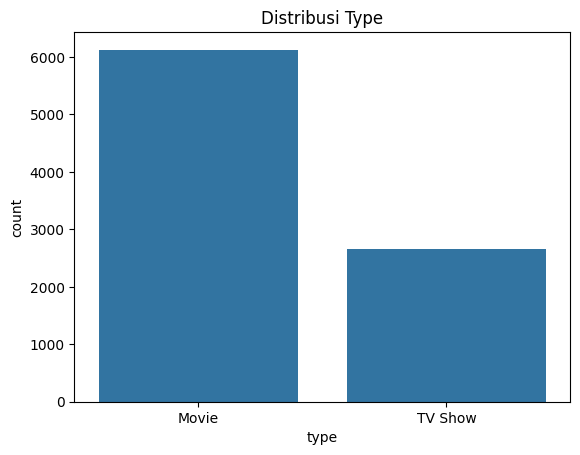

In [11]:
# Distribusi type
print(df['type'].value_counts())
sns.countplot(data=df, x='type')
plt.title('Distribusi Type')
plt.show()

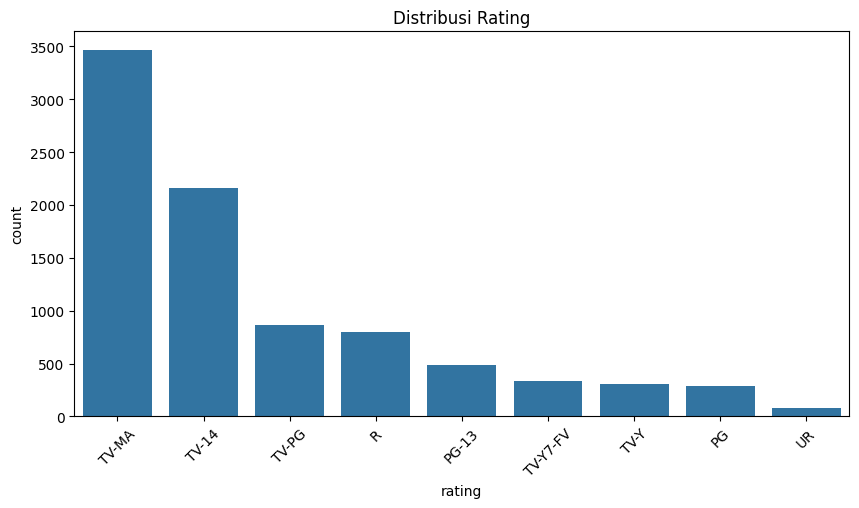

In [12]:
# Distribusi rating
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', order=df['rating'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Rating')
plt.show()

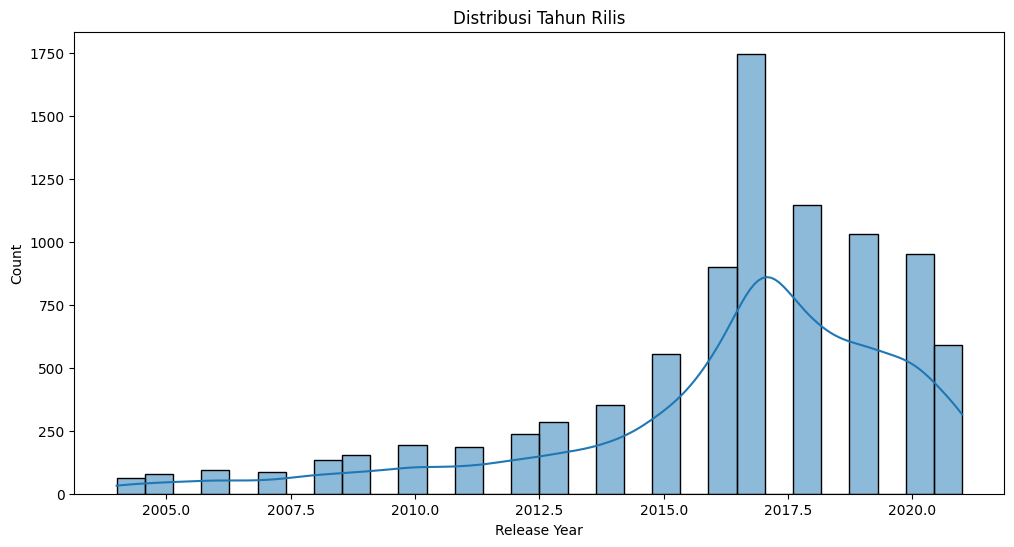

In [13]:
# Distribusi release_year
plt.figure(figsize=(12, 6))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title('Distribusi Tahun Rilis')
plt.xlabel('Release Year')
plt.show()

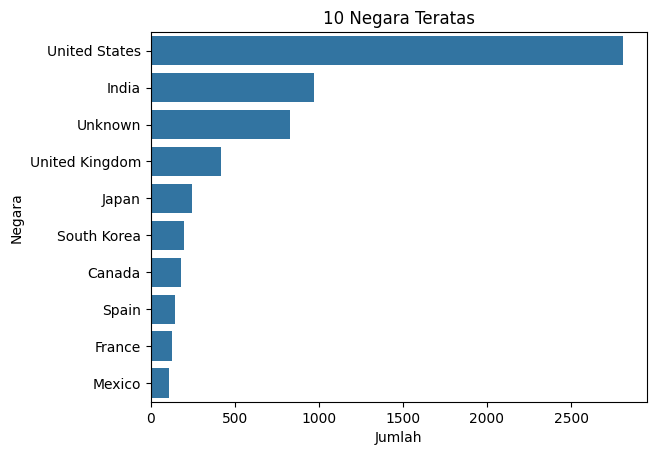

In [14]:
# Negara paling sering muncul
top_countries = df['country'].value_counts().nlargest(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('10 Negara Teratas')
plt.xlabel('Jumlah')
plt.ylabel('Negara')
plt.show()

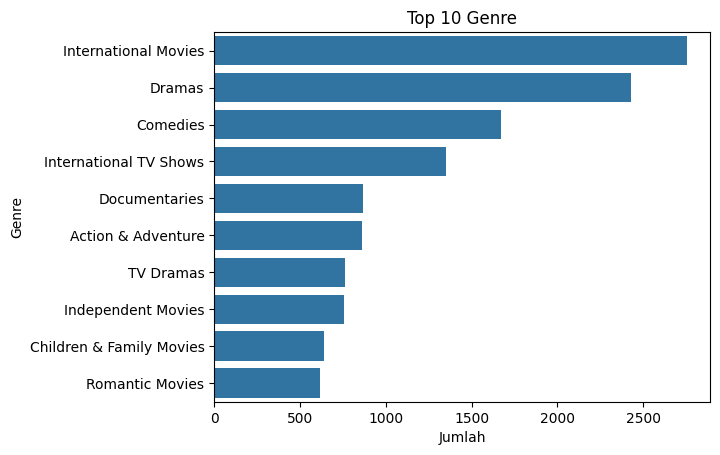

In [15]:
# Distribusi Genre (listed_in) Teratas
all_genres = ','.join(df['listed_in']).split(',')
genre_counts = Counter([genre.strip() for genre in all_genres])
top_genres = genre_counts.most_common(10)

genres, counts = zip(*top_genres)
sns.barplot(x=counts, y=genres)
plt.title('Top 10 Genre')
plt.xlabel('Jumlah')
plt.ylabel('Genre')
plt.show()

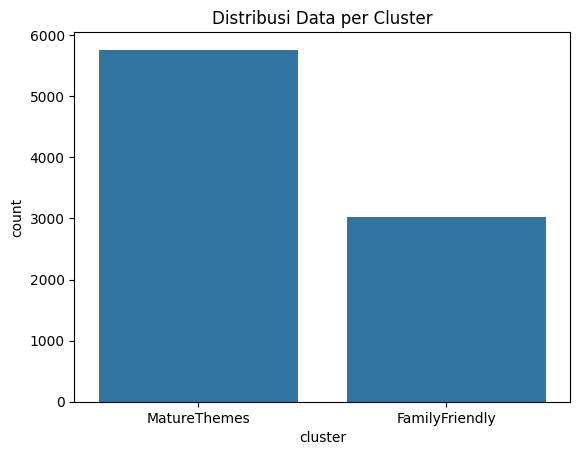

In [16]:
# Distribusi per cluster
sns.countplot(data=df, x='cluster')
plt.title('Distribusi Data per Cluster')
plt.show()

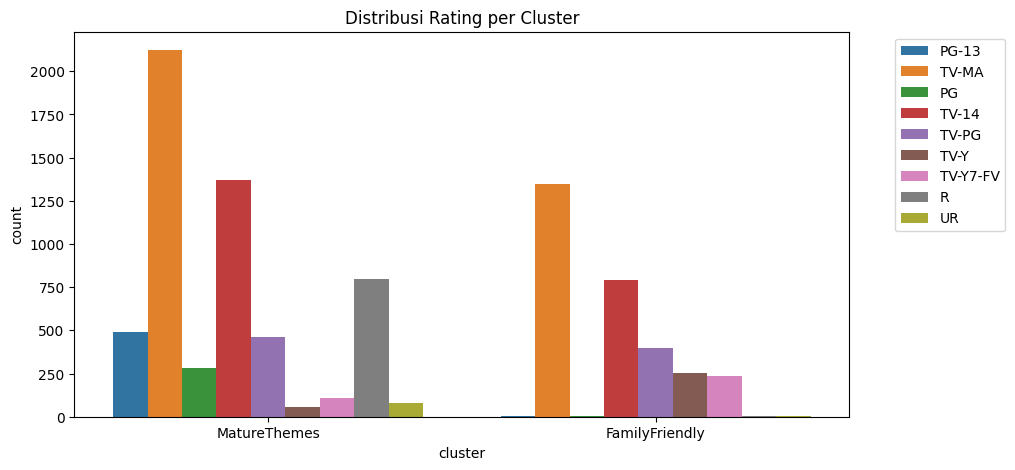

In [17]:
# Cluster vs Rating
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='cluster', hue='rating')
plt.title('Distribusi Rating per Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [18]:
# Fungsi encoding & simpan encoder ke MLflow
def encode_label_columns(df, columns):
    encoders = {}

    # Folder penyimpanan encoder
    os.makedirs("encoders", exist_ok=True)

    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

        # Logging ke MLflow
        mlflow.log_param(f"{col}_classes", list(le.classes_))

        # Simpan encoder ke file
        filepath = f'encoders/{col}_label_encoder.pkl'
        joblib.dump(le, filepath)

        # Log sebagai artifact
        mlflow.log_artifact(filepath)

    return df, encoders

# Run MLflow untuk encoding
with mlflow.start_run(run_name="Encoding type & cluster (v1.0)"):

    categorical_cols = ['type', 'cluster']
    df_encoded, encoders = encode_label_columns(df, categorical_cols)

    mlflow.log_metric("encoded_num_columns", len(df_encoded.columns))
    print("✅ Kolom 'type' dan 'cluster' berhasil di-encode & encoder disimpan di MLflow.")

✅ Kolom 'type' dan 'cluster' berhasil di-encode & encoder disimpan di MLflow.


In [19]:
# cek hasil encoding type dan cluster
df.head()

,Unnamed: 0,type,release_year,country,rating,duration,title,listed_in,date_added,cluster
0,0,0,2020.0,United States,PG-13,90 min,Dick Johnson Is Dead,Documentaries,"September 25, 2021",1
1,1,1,2021.0,South Africa,TV-MA,2 Seasons,Blood & Water,"International TV Shows, TV Dramas, TV Mysteries","September 24, 2021",0
2,2,1,2021.0,Unknown,TV-MA,1 Season,Ganglands,"Crime TV Shows, International TV Shows, TV Act...","September 24, 2021",0
3,3,1,2021.0,Unknown,TV-MA,1 Season,Jailbirds New Orleans,"Docuseries, Reality TV","September 24, 2021",0
4,4,1,2021.0,India,TV-MA,2 Seasons,Kota Factory,"International TV Shows, Romantic TV Shows, TV ...","September 24, 2021",0


In [20]:
# hapus kolom unamed
df.drop(['Unnamed: 0', 'title'], axis=1, inplace=True)

In [22]:
# Fungsi encoding ordinal untuk kolom rating
def encode_rating_column(df, column='rating', pkl_path='rating_encoder.pkl'):
    # Inisialisasi encoder dengan kategori tersusun
    encoder = OrdinalEncoder(categories=[[
        'G', 'PG', 'PG-13', 'R', 'TV-MA', 'Not Rated',
        'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'TV-G',
        'NC-17', 'NR', 'UR', 'TV-Y7-FV'
    ]])

    # Reshape data jadi 2D sebelum fit
    reshaped = df[[column]].values
    df[column] = encoder.fit_transform(reshaped).astype(int)

    # Simpan encoder ke file .pkl
    os.makedirs("encoders", exist_ok=True)
    joblib.dump(encoder, f'encoders/{pkl_path}')
    mlflow.log_artifact(f'encoders/{pkl_path}')

    # Logging ke MLflow
    mlflow.log_param(f"{column}_encoding_type", "OrdinalEncoder")
    mlflow.log_param(f"{column}_categories", list(encoder.categories_[0]))

    return df, encoder

with mlflow.start_run(run_name="Encoding Rating pakai OrdinalEncoder"):
    df_encoded_rating, rating_encoder = encode_rating_column(
        df_encoded, column="rating", pkl_path="rating_encoder.pkl"
    )
    mlflow.log_metric("encoded_rating_rows", len(df_encoded_rating))
    print("✅ Kolom 'rating' berhasil di-encode pakai OrdinalEncoder dan encoder disimpan.")

✅ Kolom 'rating' berhasil di-encode pakai OrdinalEncoder dan encoder disimpan.


In [23]:
# lihat data after ordinal encoding
df.head()

,type,release_year,country,rating,duration,listed_in,date_added,cluster
0,0,2020.0,United States,2,90 min,Documentaries,"September 25, 2021",1
1,1,2021.0,South Africa,4,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","September 24, 2021",0
2,1,2021.0,Unknown,4,1 Season,"Crime TV Shows, International TV Shows, TV Act...","September 24, 2021",0
3,1,2021.0,Unknown,4,1 Season,"Docuseries, Reality TV","September 24, 2021",0
4,1,2021.0,India,4,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...","September 24, 2021",0


In [24]:
# fungsi binary encoding kolom cosunty dan listed_in
def encode_binary_column(df, column, pkl_path):
    import category_encoders as ce
    import pickle

    encoder = ce.BinaryEncoder(cols=[column])
    encoded = encoder.fit_transform(df[[column]])
    df = df.drop(columns=[column])
    df_encoded = pd.concat([df, encoded], axis=1)

    # Logging ke MLflow
    mlflow.log_param(f"{column}_encoding_type", "binary_encoding")
    mlflow.log_metric(f"{column}_encoded_columns", encoded.shape[1])

    # Save encoder
    with open(pkl_path, 'wb') as f:
        pickle.dump(encoder, f)
    mlflow.log_artifact(pkl_path)

    return df_encoded, encoder

# kolom listed in
with mlflow.start_run(run_name="Encoding Listed_in Binary (v1.0)"):
    df, listedin_encoder = encode_binary_column(df, column='listed_in', pkl_path="listedin_binary_encoder.pkl")
    print("✅ Kolom 'listed_in' berhasil di-encode & encoder disimpan sebagai listedin_binary_encoder.pkl.")

# kolom country
with mlflow.start_run(run_name="Encoding Country Binary (v1.0)"):
    df, country_encoder = encode_binary_column(df, column='country', pkl_path="country_binary_encoder.pkl")
    print("✅ Kolom 'country' berhasil di-encode & encoder disimpan sebagai country_binary_encoder.pkl.")

✅ Kolom 'listed_in' berhasil di-encode & encoder disimpan sebagai listedin_binary_encoder.pkl.
✅ Kolom 'country' berhasil di-encode & encoder disimpan sebagai country_binary_encoder.pkl.


In [25]:
# cek hasil category encoding kolom country dan listed in
df.head()

,type,release_year,rating,duration,date_added,cluster,listed_in_0,listed_in_1,listed_in_2,listed_in_3,...,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,0,2020.0,2,90 min,"September 25, 2021",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2021.0,4,2 Seasons,"September 24, 2021",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,2021.0,4,1 Season,"September 24, 2021",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,1,2021.0,4,1 Season,"September 24, 2021",0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,2021.0,4,2 Seasons,"September 24, 2021",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [26]:
# Fungsi Ekstrak Angka dari Duration
def extract_duration_numeric(df, pkl_path=None):
    # Ekstrak angka dari kolom duration
    df['duration_numeric'] = df['duration'].str.extract(r'(\d+)').astype(float)

    # Logging ke MLflow
    mlflow.log_param("duration_extraction", "regex_digits")
    mlflow.log_metric("duration_missing_values", df['duration_numeric'].isna().sum())
    
    # Hapus kolom asli
    df = df.drop(columns=['duration'])

    return df

with mlflow.start_run(run_name="Extract Duration (v1.0)"):
    df = extract_duration_numeric(df)
    print("✅ Durasi berhasil diekstrak dan dicatat ke MLflow.")

✅ Durasi berhasil diekstrak dan dicatat ke MLflow.


In [27]:
# cek hasil category encoding kolom country dan listed in
df.head()

,type,release_year,rating,date_added,cluster,listed_in_0,listed_in_1,listed_in_2,listed_in_3,listed_in_4,...,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9,duration_numeric
0,0,2020.0,2,"September 25, 2021",1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,90.0
1,1,2021.0,4,"September 24, 2021",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.0
2,1,2021.0,4,"September 24, 2021",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0
3,1,2021.0,4,"September 24, 2021",0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1.0
4,1,2021.0,4,"September 24, 2021",0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.0


In [28]:
# Fungsi konversi ke datetime
def process_date_column(df, column='date_added'):
    df = df.copy()
    df[column] = df[column].astype(str).str.strip()
    df[column] = pd.to_datetime(df[column], format='%B %d, %Y', errors='coerce')
    df['year'] = df[column].dt.year
    df['month'] = df[column].dt.month
    df['day'] = df[column].dt.day
    df.drop(columns=[column], inplace=True)
    return df

with mlflow.start_run(run_name="konversi date_added ke datetime (v1.0)"):
    df = process_date_column(df)
    print("✅ Date added berhasil diekstrak dan dicatat ke MLflow.")

✅ Date added berhasil diekstrak dan dicatat ke MLflow.


In [29]:
# cek hasil category encoding kolom country dan listed in
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              8790 non-null   int64  
 1   release_year      8790 non-null   float64
 2   rating            8790 non-null   int64  
 3   cluster           8790 non-null   int64  
 4   listed_in_0       8790 non-null   int64  
 5   listed_in_1       8790 non-null   int64  
 6   listed_in_2       8790 non-null   int64  
 7   listed_in_3       8790 non-null   int64  
 8   listed_in_4       8790 non-null   int64  
 9   listed_in_5       8790 non-null   int64  
 10  listed_in_6       8790 non-null   int64  
 11  listed_in_7       8790 non-null   int64  
 12  listed_in_8       8790 non-null   int64  
 13  listed_in_9       8790 non-null   int64  
 14  country_0         8790 non-null   int64  
 15  country_1         8790 non-null   int64  
 16  country_2         8790 non-null   int64  


In [ ]:
# Fungsi untuk menghitung dan menyimpan logika penanganan outlier
# Class khusus untuk penanganan outlier
class OutlierHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - 1.5 * IQR
        self.upper_bound = Q3 + 1.5 * IQR
        self.medians = X.median()
        return self

    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            low = self.lower_bound[col]
            high = self.upper_bound[col]
            median = self.medians[col]
            X[col] = np.where((X[col] < low) | (X[col] > high), median, X[col])
        return X

# Fungsi untuk menghitung dan menyimpan logika penanganan outlier
def fit_outlier_handler(df, pkl_path="outlier_handler.pkl"):
    df_numeric = df.select_dtypes(include=[np.number])

    handler = OutlierHandler()
    handler.fit(df_numeric)

    # Simpan model handler ke file .pkl
    with open(pkl_path, 'wb') as f:
        pickle.dump(handler, f)

    # Logging ke MLflow
    mlflow.log_param("outlier_strategy", "IQR + median replace (custom class)")
    mlflow.log_artifact(pkl_path)

    print("✅ Model OutlierHandler berhasil disimpan.")
    return handler

# Jalankan MLflow logging dan simpan model
with mlflow.start_run(run_name="Outlier Handling"):
    outlier_model = fit_outlier_handler(df, "outlier_handler.pkl")

✅ Model OutlierHandler berhasil disimpan.


In [31]:
# fungsi normalisasi data
def save_scaler_with_logging(
    df,
    run_name="normalization (v1.0)",
    save_scaler_path="minmax_scaler.pkl"
):
    with mlflow.start_run(run_name=run_name):
        # Ambil kolom numerik
        numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Logging parameter
        mlflow.log_param("normalized_columns", numeric_columns)
        mlflow.log_param("normalization_method", "MinMaxScaler")

        # Fit scaler ke data
        scaler = MinMaxScaler()
        scaler.fit(df[numeric_columns])

        # Simpan scaler ke file
        with open(save_scaler_path, 'wb') as f:
            pickle.dump(scaler, f)
        mlflow.log_artifact(save_scaler_path)

        print("✅ Scaler berhasil disimpan dan dicatat di MLflow.")
        return scaler

scaler = save_scaler_with_logging(df)

✅ Scaler berhasil disimpan dan dicatat di MLflow.


In [38]:
# cek hasil normalisasi
df.describe()

,type,release_year,rating,cluster,listed_in_0,listed_in_1,listed_in_2,listed_in_3,listed_in_4,listed_in_5,...,country_4,country_5,country_6,country_7,country_8,country_9,duration_numeric,year,month,day
count,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,...,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000,8790.000000
mean,0.303072,2016.366212,5.093174,0.655404,0.000455,0.086803,0.156883,0.341183,0.419909,0.476906,...,0.161320,0.229920,0.197611,0.373265,0.358020,0.610694,69.886803,2018.873606,6.655859,12.500000
std,0.459612,3.633452,2.538870,0.475263,0.021329,0.281562,0.363711,0.474134,0.493572,0.499495,...,0.367846,0.420805,0.398220,0.483699,0.479445,0.487621,50.684589,1.573568,3.436103,9.887635
min,0.000000,2004.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2008.000000,1.000000,1.000000
25%,0.000000,2015.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2018.000000,4.000000,1.000000
50%,0.000000,2017.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,88.000000,2019.000000,7.000000,13.000000
75%,1.000000,2019.000000,6.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,106.000000,2020.000000,10.000000,20.000000
max,1.000000,2021.000000,14.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,253.000000,2021.000000,12.000000,31.000000


In [40]:
# Fungsi PCA yang hanya menyimpan model
def perform_pca_and_save_model(
    df,
    cluster_column='cluster',
    n_components=2,
    run_name="PCA_Model_Saving (v1.0)",
    model_filename="pca_model.pkl",
    image_filename="pca_plot.png"
):
    with mlflow.start_run(run_name=run_name):
        # Pisahkan fitur numerik, kecuali kolom cluster
        X_numeric = df.drop(columns=[cluster_column], errors='ignore').select_dtypes(include='number')

        # Jalankan PCA
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_numeric)

        # Logging explained variance
        for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
            mlflow.log_metric(f"explained_variance_PC{i+1}", variance_ratio)

        # Simpan model PCA saja
        with open(model_filename, 'wb') as f:
            pickle.dump(pca, f)
        mlflow.log_artifact(model_filename)

        # Visualisasi jika kolom cluster ada
        if cluster_column in df.columns:
            plt.figure(figsize=(8, 6))
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[cluster_column], cmap='Set1', alpha=0.7)
            plt.title('PCA - Visualisasi Cluster')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.grid(True)
            plt.savefig(image_filename)
            plt.close()

            # Logging visualisasi ke MLflow
            mlflow.log_artifact(image_filename)

        print("✅ PCA selesai. Model PCA disimpan dan dilog ke MLflow.")
        return pca  # hanya return model
    
pca_model = perform_pca_and_save_model(df)

✅ PCA selesai. Model PCA disimpan dan dilog ke MLflow.


In [42]:
# Fungsi save data final
def save_final_data_to_csv(df_final, filename="final_dataset.csv", dataset_version="v2.0", run_name="Save Final Dataset (v1.0)"):
    with mlflow.start_run(run_name=run_name):
        # Simpan ke CSV
        df_final.to_csv(filename, index=False)

        # Log file CSV ke MLflow
        mlflow.log_artifact(filename)

        # Logging parameter versi & info dataset
        mlflow.log_param("dataset_version", dataset_version)
        mlflow.log_param("final_data_rows", df_final.shape[0])
        mlflow.log_param("final_data_columns", df_final.shape[1])
        mlflow.log_param("final_data_columns_list", ', '.join(df_final.columns))

        print(f"✅ Final dataset (versi {dataset_version}) disimpan sebagai '{filename}' dan dicatat ke MLflow.")


save_final_data_to_csv(df, filename="final_dataset.csv", dataset_version="v1.2")

✅ Final dataset (versi v1.2) disimpan sebagai 'final_dataset.csv' dan dicatat ke MLflow.


In [41]:
df.head()

,type,release_year,rating,cluster,listed_in_0,listed_in_1,listed_in_2,listed_in_3,listed_in_4,listed_in_5,...,country_4,country_5,country_6,country_7,country_8,country_9,duration_numeric,year,month,day
0,0,2020.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,1,90.0,2021,9,25
1,1,2021.0,4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2.0,2021,9,24
2,1,2021.0,4,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1.0,2021,9,24
3,1,2021.0,4,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1.0,2021,9,24
4,1,2021.0,4,0,0,0,0,0,0,0,...,0,0,0,1,0,0,2.0,2021,9,24
